## Buisness Objective 
The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

### Approach

1. Importing Data and Data preparation
- Filtering high value Customers
- Dropping features with no variance
- Deriving new feature
- Labelling Churn status
- Missing Value Treatment
- Outlier Treatment
- Univariate, Bivariate and Multivariate Analysis
- Splitting Data into Train test sets
- Feature Scaling 
- Data Imbalance treatment

2. Building predictor Model
- Build Decision Tree model with best parameters and calculate performance metrics
- Build Random Forest Classifier model with best parameters and calculate performance metrics
- Build Logistic Regression model with optimum cutoff and calculate performance metrics

3. Business Recommendation

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# Model Building
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay


In [2]:
telecom = pd.read_csv("telecom_churn_data.csv")

In [3]:
# Setting mobile_number as index as it is a unique identifier for a customer
telecom.set_index('mobile_number', inplace = True)

In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 7000842753 to 7001905007
Columns: 225 entries, circle_id to sep_vbc_3g
dtypes: float64(179), int64(34), object(12)
memory usage: 172.4+ MB


In [5]:
# All the operations will be done on df instead of telecom
cust = telecom.copy()

### Filtering high value customers

Filtering the high value customers for the given dataset. Futher analysis will be done on high value customers only.

**High-Value Customers** : Those who have recharged with an amount more than or equal to 70th percentile of the average amount in the first 2 months (the good phase)

In [6]:
## av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
# checking for missing values in av_rech_amt_data_6 and av_rech_amt_data_7

print(cust['av_rech_amt_data_6'].isnull().mean() * 100)
print(cust['av_rech_amt_data_7'].isnull().mean() * 100)

74.84674846748467
74.42874428744287


In [7]:
cust[['av_rech_amt_data_6', 'av_rech_amt_data_7']].describe()

,av_rech_amt_data_6,av_rech_amt_data_7
count,25153.000000,25571.000000
mean,192.600982,200.981292
std,192.646318,196.791224
min,1.000000,0.500000
25%,82.000000,92.000000
50%,154.000000,154.000000
75%,252.000000,252.000000
max,7546.000000,4365.000000


In [8]:
# Filling null values with 0 as customer didnot make a recharge in these months. Hence imputting values in the 2 columns with 0
cust['av_rech_amt_data_6'] = cust.av_rech_amt_data_6.fillna(0)
cust['av_rech_amt_data_7'] = cust.av_rech_amt_data_7.fillna(0)

In [9]:
# seperate column to get total recharge in the 6 and 7 th month
cust['av_rech_amt_data_6_7'] = cust['av_rech_amt_data_6'] + cust['av_rech_amt_data_7'] 

In [10]:
# creating seperate datafram for high value customers
High_value_customers = cust[cust['av_rech_amt_data_6_7'] >= cust['av_rech_amt_data_6_7'].quantile(.70)]
High_value_customers.drop('av_rech_amt_data_6_7', axis=1, inplace=True)
High_value_customers.shape

(30378, 225)

**As mentioned,approx 30k records containg high value customers**

### Dropping Features with no variance

In [12]:
High_value_customers.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
mobile_number,,,,,,,,,,,,,,,,,,,,,
7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,...,0,1.0,1.0,1.0,NaN,968,30.40,0.00,101.20,3.58
7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,...,0,NaN,1.0,1.0,NaN,1006,0.00,0.00,0.00,0.00
7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,...,0,0.0,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00
7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,492.223,...,0,NaN,1.0,1.0,NaN,315,21.03,910.65,122.16,0.00
7001864400,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,119.518,247.435,...,0,NaN,1.0,NaN,NaN,902,0.00,0.00,0.00,0.00


In [13]:
skewed = []
for col in High_value_customers.columns:
    if len(High_value_customers[col].value_counts()) == 1:
        skewed.append(col)
        print(High_value_customers[col].value_counts())

print(skewed)
print(len(skewed))

circle_id
109    30378
Name: count, dtype: int64
loc_og_t2o_mou
0.0    29965
Name: count, dtype: int64
std_og_t2o_mou
0.0    29965
Name: count, dtype: int64
loc_ic_t2o_mou
0.0    29965
Name: count, dtype: int64
last_date_of_month_6
6/30/2014    30378
Name: count, dtype: int64
last_date_of_month_7
7/31/2014    30319
Name: count, dtype: int64
last_date_of_month_8
8/31/2014    30143
Name: count, dtype: int64
last_date_of_month_9
9/30/2014    29940
Name: count, dtype: int64
std_og_t2c_mou_6
0.0    29312
Name: count, dtype: int64
std_og_t2c_mou_7
0.0    29293
Name: count, dtype: int64
std_og_t2c_mou_8
0.0    28587
Name: count, dtype: int64
std_og_t2c_mou_9
0.0    27886
Name: count, dtype: int64
std_ic_t2o_mou_6
0.0    29312
Name: count, dtype: int64
std_ic_t2o_mou_7
0.0    29293
Name: count, dtype: int64
std_ic_t2o_mou_8
0.0    28587
Name: count, dtype: int64
std_ic_t2o_mou_9
0.0    27886
Name: count, dtype: int64
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_dat

In [14]:
High_value_customers.drop(skewed, axis=1, inplace=True)

**Tagging customers as churn or not**
Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9
total_og_mou_9
vol_2g_mb_9
vol_3g_mb_9

In [15]:
in_calls_9 = High_value_customers['total_ic_mou_9'] <= 0
out_calls_9 = High_value_customers['total_og_mou_9'] <= 0

data_2g_9 = High_value_customers['vol_2g_mb_9'] <= 0
data_3g_9 = High_value_customers['vol_3g_mb_9'] <= 0
cond = ((in_calls_9 & out_calls_9) & (data_2g_9 & data_3g_9))

In [16]:
High_value_customers['Churned'] = np.where(cond,1,0)

In [17]:
High_value_customers['Churned'].value_counts(normalize=True)* 100

Churned
0    91.549806
1     8.450194
Name: proportion, dtype: float64

In [18]:
features_9 = High_value_customers.columns[High_value_customers.columns.str.endswith("_9")]

In [19]:
print(features_9.shape[0])
High_value_customers.drop(features_9,axis=1,inplace=True)
print(High_value_customers.shape)

51
(30378, 159)


### Deriving new features

In [20]:
High_value_customers.columns[High_value_customers.columns.str.startswith('date_of')]

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

In [21]:
rech_df = High_value_customers[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8']]

In [22]:
rech_df.isnull().sum()

date_of_last_rech_6          171
date_of_last_rech_7          217
date_of_last_rech_8          758
date_of_last_rech_data_6    6147
date_of_last_rech_data_7    5689
date_of_last_rech_data_8    9877
dtype: int64

In [23]:
# we will create new feature for last reacharge and last_recharge_data by combining all three months details
rech_df.head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
mobile_number,,,,,,
7000842753,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7001865778,6/29/2014,7/31/2014,8/28/2014,NaN,7/25/2014,8/10/2014
7000142493,6/26/2014,7/28/2014,8/9/2014,6/4/2014,NaN,NaN
7001524846,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
7001864400,6/29/2014,7/23/2014,8/29/2014,NaN,7/23/2014,NaN


In [24]:
rech_df = rech_df.applymap(pd.to_datetime)

In [25]:
rech_df['date_of_last_rech'] = rech_df[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].max(axis=1)
rech_df['date_of_last_rech_data'] = rech_df[['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']].max(axis=1)

In [26]:
rech_df[['date_of_last_rech', 'date_of_last_rech_data']].isnull().sum()

date_of_last_rech         0
date_of_last_rech_data    0
dtype: int64

In [27]:
reference_date = '9/1/2014'   ## 1 st of sepetember as the customer churn month starting
rech_df['ref_date'] = pd.to_datetime(reference_date)
# converting it ot interger to feed it in models

rech_df['no_of_days_since_last_rech']= rech_df['ref_date'] - rech_df['date_of_last_rech']
rech_df['no_of_days_since_last_rech_data']= rech_df['ref_date'] - rech_df['date_of_last_rech_data']

In [28]:
High_value_customers['no_of_days_since_last_rech'] = rech_df['no_of_days_since_last_rech'].dt.days.astype('int64')
High_value_customers['no_of_days_since_last_rech_data'] = rech_df['no_of_days_since_last_rech_data'].dt.days.astype('int64')

In [29]:
High_value_customers.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'], axis=1, inplace= True)

#### For comparing the data of good phase (6 and 7) with action phase (8) 

In [30]:
# checking the no of columns for eaCH MONTH TO DERIVE COMPARITIVE DATA
print(High_value_customers.columns[High_value_customers.columns.str.endswith("_6")].shape)
print(High_value_customers.columns[High_value_customers.columns.str.endswith("_7")].shape)
print(High_value_customers.columns[High_value_customers.columns.str.endswith("_8")].shape)

(49,)
(49,)
(49,)


In [31]:
features =[]

for col in High_value_customers.columns:
    if col.endswith("_6") | col.endswith("_7") | col.endswith("_8"):
        features.append(col)

from collections import defaultdict
def convert_to_list_of_lists(data):
    prefix_dict = defaultdict(list)
    for item in data:
        prefix = '_'.join(item.split('_')[:-1])
        prefix_dict[prefix].append(item)
    return list(prefix_dict.values())

# Convert the flat list to list of lists
monthly_features = convert_to_list_of_lists(features)


In [32]:
for i in range(len(monthly_features)):
    feat_6 = monthly_features[i][0]
    feat_7 = monthly_features[i][1]
    feat_8 = monthly_features[i][2]
    
    new_feat = "derived_" + feat_6[:-2]
    High_value_customers[new_feat] = ((High_value_customers[feat_6]+High_value_customers[feat_7])/2) - High_value_customers[feat_8]
    
# dropping the individual month features as deriving new features
High_value_customers.drop(features, axis=1, inplace=True)

In [33]:
High_value_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30378 entries, 7000842753 to 7001905007
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   aon                              30378 non-null  int64  
 1   aug_vbc_3g                       30378 non-null  float64
 2   jul_vbc_3g                       30378 non-null  float64
 3   jun_vbc_3g                       30378 non-null  float64
 4   sep_vbc_3g                       30378 non-null  float64
 5   Churned                          30378 non-null  int32  
 6   no_of_days_since_last_rech       30378 non-null  int64  
 7   no_of_days_since_last_rech_data  30378 non-null  int64  
 8   derived_arpu                     30378 non-null  float64
 9   derived_onnet_mou                27897 non-null  float64
 10  derived_offnet_mou               27897 non-null  float64
 11  derived_roam_ic_mou              27897 non-null  float64
 12  derived_r

In [34]:
High_value_customers['derived_vbc_3g'] = ((High_value_customers['jun_vbc_3g']  + High_value_customers['jul_vbc_3g'])/2 - High_value_customers['aug_vbc_3g'])

In [35]:
High_value_customers[['jun_vbc_3g','jul_vbc_3g', 'aug_vbc_3g', 'derived_vbc_3g']].head(10)

,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g,derived_vbc_3g
mobile_number,,,,
7000842753,101.20,0.00,30.40,20.200
7001865778,0.00,0.00,0.00,0.000
7000142493,0.00,0.00,0.00,0.000
7001524846,122.16,910.65,21.03,495.375
7001864400,0.00,0.00,0.00,0.000
7001754084,0.00,466.06,454.53,-221.500
7000887461,0.00,51.86,40.45,-14.520
7000335166,0.00,0.00,0.00,0.000
7000382876,0.00,0.00,0.00,0.000


In [36]:
 # again dropping the redundant features

High_value_customers.drop(['jun_vbc_3g','jul_vbc_3g', 'aug_vbc_3g', 'sep_vbc_3g'], axis=1, inplace=True)

### Handling Missing value

In [38]:
feat_with_high_missing_value =[]
for feat in High_value_customers.columns:
    if High_value_customers[feat].isnull().mean()>.40:
        feat_with_high_missing_value.append(feat)
        print(feat, High_value_customers[feat].isnull().mean().round(2) * 100)

derived_total_rech_data 50.0
derived_max_rech_data 50.0
derived_count_rech_2g 50.0
derived_count_rech_3g 50.0
derived_arpu_3g 50.0
derived_arpu_2g 50.0
derived_night_pck_user 50.0
derived_fb_user 50.0


In [39]:
# Dropping the features with high ~50% missing values
High_value_customers.drop(feat_with_high_missing_value, axis=1,inplace=True)

In [40]:
feat_missing_value = High_value_customers.columns[High_value_customers.isnull().mean() * 100 > 0]

In [41]:
High_value_customers[feat_missing_value].describe()

,derived_onnet_mou,derived_offnet_mou,derived_roam_ic_mou,derived_roam_og_mou,derived_loc_og_t2t_mou,derived_loc_og_t2m_mou,derived_loc_og_t2f_mou,derived_loc_og_t2c_mou,derived_loc_og_mou,derived_std_og_t2t_mou,...,derived_loc_ic_t2f_mou,derived_loc_ic_mou,derived_std_ic_t2t_mou,derived_std_ic_t2m_mou,derived_std_ic_t2f_mou,derived_std_ic_mou,derived_spl_ic_mou,derived_isd_ic_mou,derived_ic_others,derived_av_rech_amt_data
count,27897.000000,27897.000000,27897.000000,27897.000000,27897.00000,27897.000000,27897.000000,27897.000000,27897.000000,27897.000000,...,27897.000000,27897.000000,27897.000000,27897.000000,27897.000000,27897.000000,27897.000000,27897.000000,27897.000000,20501.000000
mean,6.226165,6.728570,0.509489,0.926678,2.96879,1.447753,0.194155,-0.009477,4.610822,2.697712,...,0.872445,1.008009,0.135979,0.499450,0.092756,0.728199,0.011554,-0.192756,0.001789,-27.854161
std,206.373836,235.885186,58.496924,67.428171,119.64357,113.045905,9.038426,6.229936,174.650466,164.045758,...,30.606745,173.791059,51.816193,66.420859,14.547897,87.767617,0.184172,58.621141,9.054843,160.927301
min,-4745.845000,-4987.660000,-2330.200000,-3023.745000,-4481.30000,-1979.685000,-295.140000,-193.355000,-4619.975000,-4745.295000,...,-953.395000,-4302.510000,-3313.875000,-2523.275000,-1023.320000,-3321.395000,-5.590000,-3163.690000,-528.355000,-1905.500000
25%,-11.845000,-31.665000,0.000000,0.000000,-6.66000,-18.565000,-0.100000,0.000000,-26.480000,0.000000,...,-1.510000,-34.140000,0.000000,-1.860000,0.000000,-3.960000,0.000000,0.000000,0.000000,-87.000000
50%,0.515000,2.630000,0.000000,0.000000,0.18000,0.735000,0.000000,0.000000,1.155000,0.000000,...,0.000000,1.595000,0.000000,0.000000,0.000000,0.115000,0.000000,0.000000,0.000000,-2.500000
75%,19.325000,43.215000,0.000000,0.000000,9.63500,23.305000,0.930000,0.365000,34.310000,1.550000,...,2.865000,37.645000,1.230000,4.250000,0.105000,6.960000,0.000000,0.000000,0.000000,40.000000
max,3875.375000,7094.390000,1274.385000,2410.835000,3875.37500,2863.535000,223.820000,82.580000,3867.830000,3530.210000,...,1056.820000,3049.925000,2710.285000,1777.590000,636.500000,2777.350000,16.280000,5534.595000,408.240000,3486.500000


Fairly Symmetrical: Skewness between -0.5 and 0.5 indicates that the distribution is fairly symmetrical1.
Moderately Skewed: Skewness between -1 and -0.5 (negative skew) or 0.5 and 1 (positive skew) indicates moderate skewness1.
Highly Skewed: Skewness less than -1 (negative skew) or greater than 1 (positive skew) indicates a highly skewed distribution1.

**checking skewness of all these fields**

In [42]:
for feat in feat_missing_value:
    print(feat, High_value_customers[feat].skew())

derived_onnet_mou -1.223988709541954
derived_offnet_mou 0.7083844333231529
derived_roam_ic_mou -9.599994122081737
derived_roam_og_mou -6.24294206068412
derived_loc_og_t2t_mou -1.7321337758383033
derived_loc_og_t2m_mou 0.24114167491648636
derived_loc_og_t2f_mou -1.1707560430767303
derived_loc_og_t2c_mou -4.750818019688506
derived_loc_og_mou -0.5522233598086447
derived_std_og_t2t_mou -1.707287055100246
derived_std_og_t2m_mou 0.13389782497083966
derived_std_og_t2f_mou -3.3699450673363716
derived_std_og_mou 0.11934380629637346
derived_isd_og_mou -13.99471493248603
derived_spl_og_mou -8.142742666478474
derived_og_others 70.1844907632745
derived_loc_ic_t2t_mou -1.7086201504067229
derived_loc_ic_t2m_mou -2.7295139582133943
derived_loc_ic_t2f_mou 2.7901864107966095
derived_loc_ic_mou -1.208237065739611
derived_std_ic_t2t_mou -6.150959514423517
derived_std_ic_t2m_mou -1.78098055742024
derived_std_ic_t2f_mou -10.556913967685269
derived_std_ic_mou -2.3669833946879657
derived_spl_ic_mou 30.5817631

In [43]:
for feat in feat_missing_value:
    High_value_customers[feat] = High_value_customers[feat].fillna(High_value_customers[feat].median())

### Handling Outliers

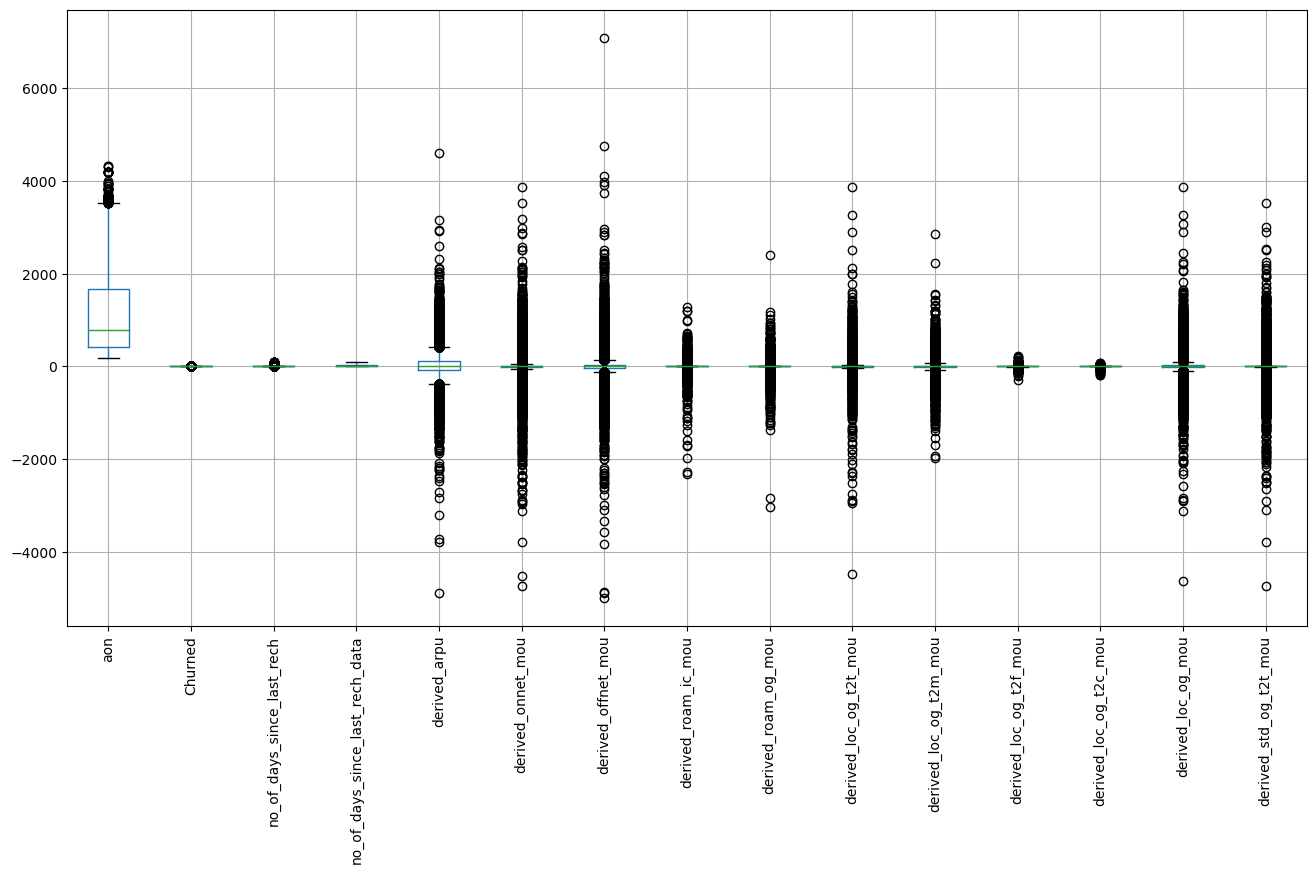

In [44]:
plt.figure(figsize=(16,8))
High_value_customers.iloc[:,:15].boxplot()
plt.xticks(rotation=90)
plt.show()

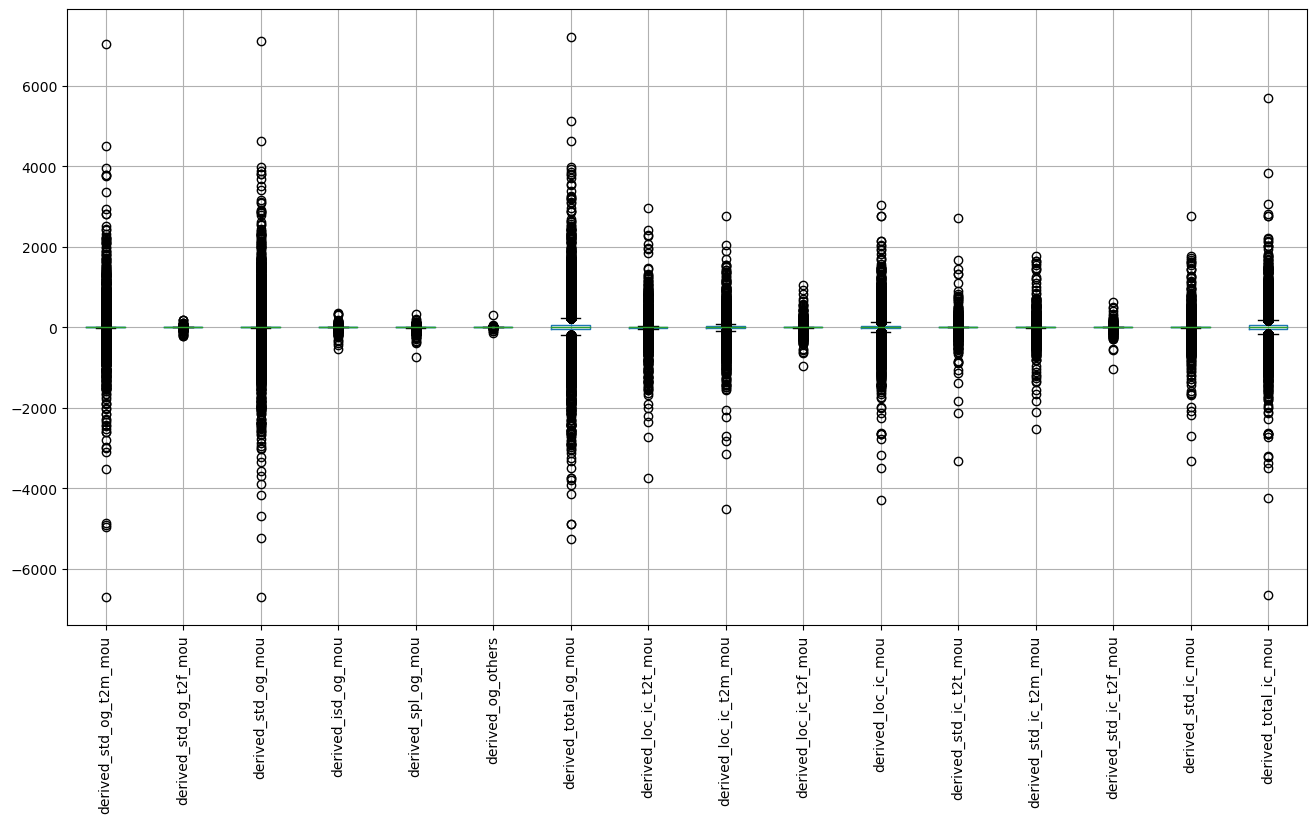

In [45]:
plt.figure(figsize=(16,8))
High_value_customers.iloc[:,15:31].boxplot()
plt.xticks(rotation=90)
plt.show()

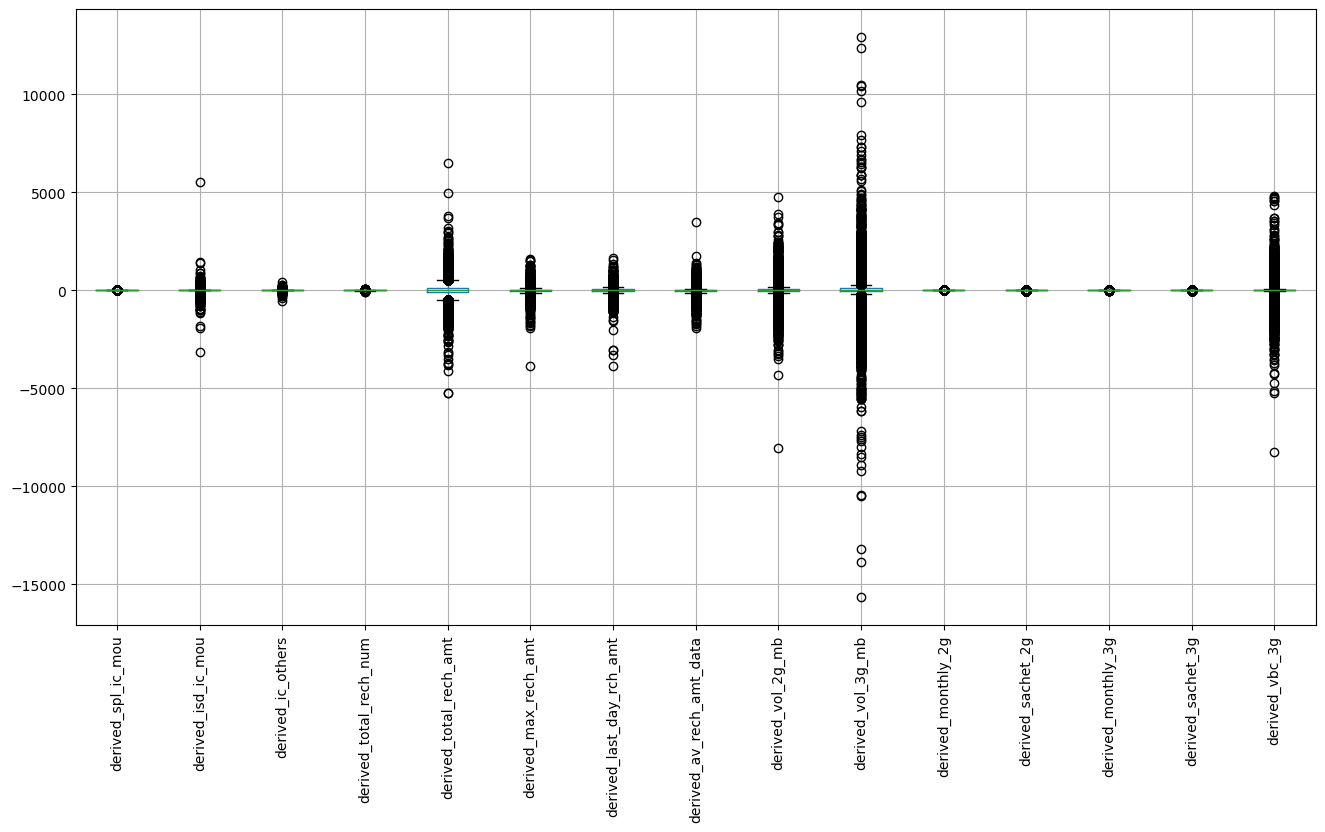

In [46]:
plt.figure(figsize=(16,8))
High_value_customers.iloc[:,31:].boxplot()
plt.xticks(rotation=90)
plt.show()

Most of the features have high number of outliers, dropping the outliers will cause loss of information. Hence capping and flooring the extremes values

In [47]:
# except churned column cappin all the columns to UB and LB of whiskers
var = High_value_customers.drop('Churned', axis=1).columns

for data in var:
    Q1= High_value_customers[data].describe()['25%']
    Q3= High_value_customers[data].describe()['75%']
    IQR = Q3 - Q1
    UB = Q3 + 1.5 * IQR
    LB = Q1 - 1.5 * IQR
    High_value_customers[data] = np.where(High_value_customers[data] > UB, UB, High_value_customers[data])
    High_value_customers[data] = np.where(High_value_customers[data] < LB, LB, High_value_customers[data])

### Checking Correlations

In [48]:
second_half = High_value_customers.columns[24:]
second_half = second_half.append(High_value_customers.columns[1:2])
second_half

Index(['derived_loc_ic_t2f_mou', 'derived_loc_ic_mou',
       'derived_std_ic_t2t_mou', 'derived_std_ic_t2m_mou',
       'derived_std_ic_t2f_mou', 'derived_std_ic_mou', 'derived_total_ic_mou',
       'derived_spl_ic_mou', 'derived_isd_ic_mou', 'derived_ic_others',
       'derived_total_rech_num', 'derived_total_rech_amt',
       'derived_max_rech_amt', 'derived_last_day_rch_amt',
       'derived_av_rech_amt_data', 'derived_vol_2g_mb', 'derived_vol_3g_mb',
       'derived_monthly_2g', 'derived_sachet_2g', 'derived_monthly_3g',
       'derived_sachet_3g', 'derived_vbc_3g', 'Churned'],
      dtype='object')

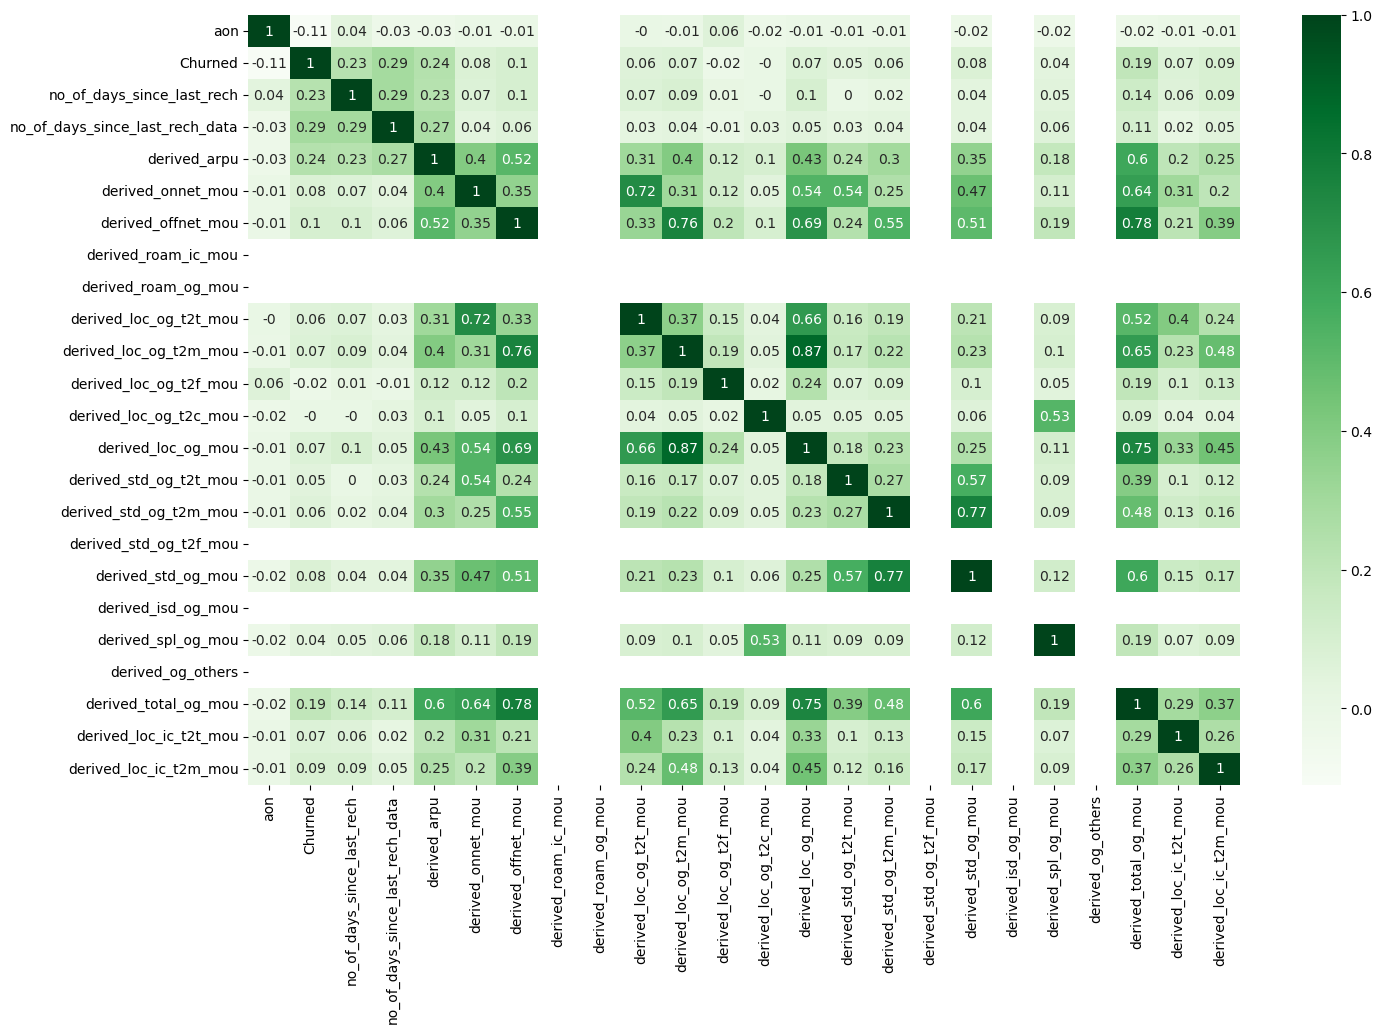

In [49]:
# Checking for correlation between first 23 features with Churned

plt.figure(figsize=(16,10))
sns.heatmap(np.round(High_value_customers.iloc[:,:24].corr(), 2), annot=True, cmap='Greens')
plt.show()

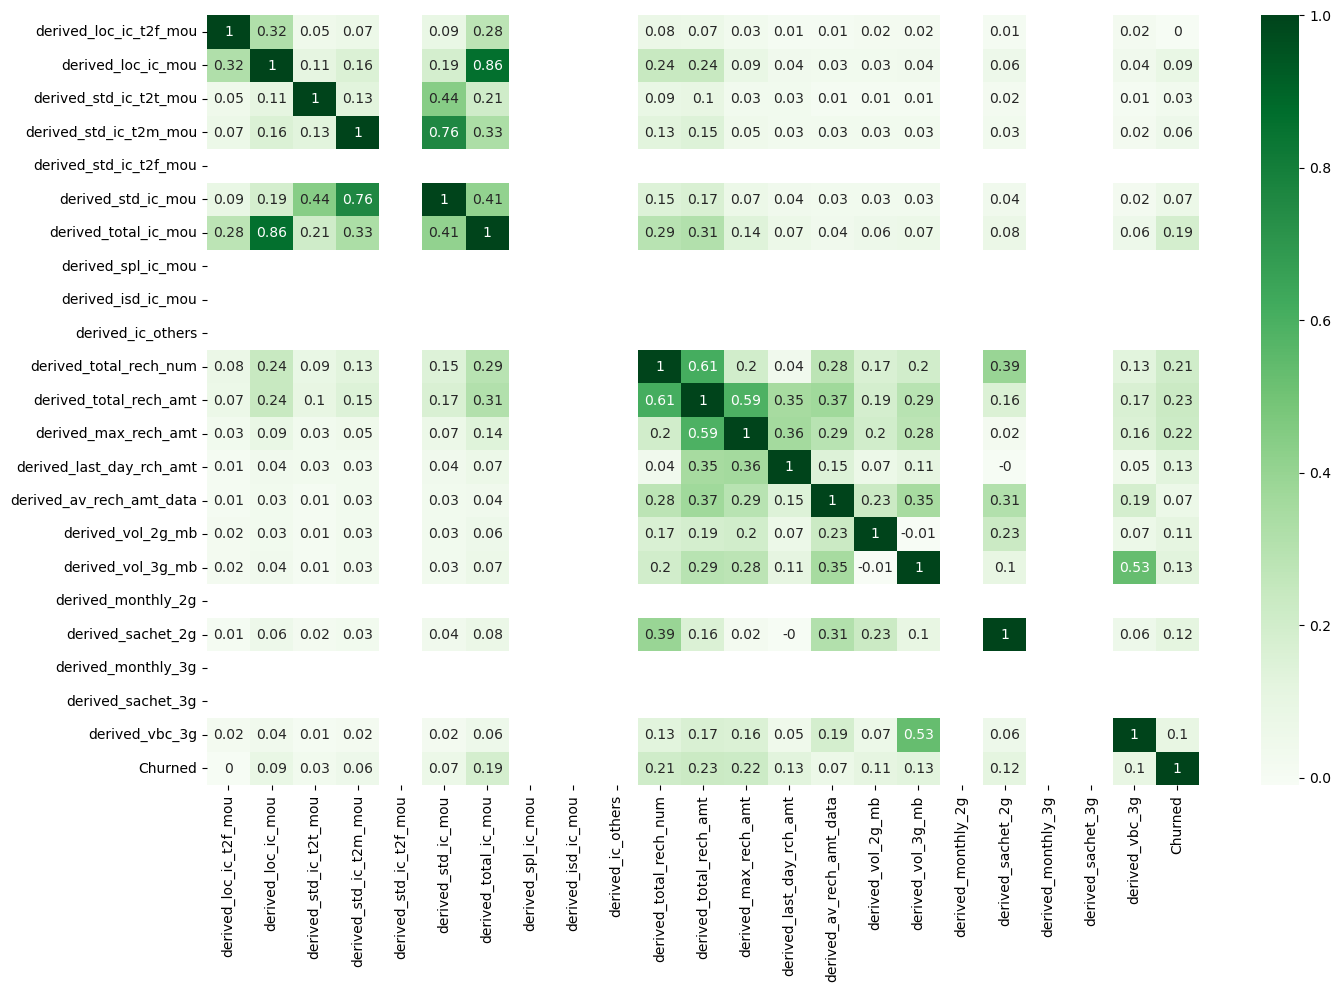

In [50]:
# Checking for correlation between second half 23 features with Churned

plt.figure(figsize=(16,10))
sns.heatmap(np.round(High_value_customers[second_half].corr(),2), annot=True, cmap='Greens')
plt.show()

In [51]:
# Few features showing no relations to any other feature due to no variance hence deleting those columns
skewed = []
for x in High_value_customers.columns:
    if len(High_value_customers[x].value_counts())==1:
        skewed.append(x)
        print(High_value_customers[x].value_counts())
print(skewed)


derived_roam_ic_mou
0.0    30378
Name: count, dtype: int64
derived_roam_og_mou
0.0    30378
Name: count, dtype: int64
derived_std_og_t2f_mou
0.0    30378
Name: count, dtype: int64
derived_isd_og_mou
0.0    30378
Name: count, dtype: int64
derived_og_others
0.0    30378
Name: count, dtype: int64
derived_std_ic_t2f_mou
0.0    30378
Name: count, dtype: int64
derived_spl_ic_mou
0.0    30378
Name: count, dtype: int64
derived_isd_ic_mou
0.0    30378
Name: count, dtype: int64
derived_ic_others
0.0    30378
Name: count, dtype: int64
derived_monthly_2g
0.0    30378
Name: count, dtype: int64
derived_monthly_3g
0.0    30378
Name: count, dtype: int64
derived_sachet_3g
0.0    30378
Name: count, dtype: int64
['derived_roam_ic_mou', 'derived_roam_og_mou', 'derived_std_og_t2f_mou', 'derived_isd_og_mou', 'derived_og_others', 'derived_std_ic_t2f_mou', 'derived_spl_ic_mou', 'derived_isd_ic_mou', 'derived_ic_others', 'derived_monthly_2g', 'derived_monthly_3g', 'derived_sachet_3g']


In [52]:
High_value_customers.drop(skewed, axis=1, inplace=True)
High_value_customers.head()

,aon,Churned,no_of_days_since_last_rech,no_of_days_since_last_rech_data,derived_arpu,derived_onnet_mou,derived_offnet_mou,derived_loc_og_t2t_mou,derived_loc_og_t2m_mou,derived_loc_og_t2f_mou,...,derived_total_ic_mou,derived_total_rech_num,derived_total_rech_amt,derived_max_rech_amt,derived_last_day_rch_amt,derived_av_rech_amt_data,derived_vol_2g_mb,derived_vol_3g_mb,derived_sachet_2g,derived_vbc_3g
mobile_number,,,,,,,,,,,,,,,,,,,,,
7000842753,968.0,1,17.0,24.0,-7.7025,0.51500,2.6300,0.180,0.73500,0.0,...,-5.440000,1.5,55.0,0.0,0.0,0.0,9.97500,7.555000,0.00,20.20000
7001865778,1006.0,0,4.0,22.0,-73.7605,43.71500,-119.6825,27.740,-67.85375,0.0,...,-167.910625,-4.5,-54.0,34.0,3.5,27.0,-124.10375,0.000000,-0.75,0.00000
7000142493,1526.0,0,17.0,89.0,47.5820,15.98500,-39.8400,15.985,-44.50000,0.0,...,-131.445000,2.5,-14.0,-27.0,-30.0,-2.5,0.00000,0.000000,0.50,0.00000
7001524846,315.0,0,2.0,9.0,298.1100,53.27625,-48.8350,27.740,25.23000,0.0,...,49.635000,6.0,399.0,92.0,15.0,19.5,177.97000,288.208125,-0.75,67.99625
7001864400,902.0,0,3.0,40.0,13.2455,9.57000,-19.5200,9.570,4.11500,0.0,...,95.785000,-2.0,-2.5,82.0,102.0,-2.5,3.68500,0.000000,0.00,0.00000


Observation: 
    1. T2T has high correlation with ONNET (.72) which is obvious as both both carreies same data on the same operator network.
    2. T2M has high correlation with OFFNET (.76)
    3. Also , there are high correlations with recharge amount and numbers
    These can futher leads to multicollinearity and we need to handle it, which will do later.
    

### Splitting Data into Training and Test set

In [53]:
X = High_value_customers.drop(['Churned'], axis=1)
y = High_value_customers['Churned']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify = y,random_state= 42)

In [54]:
print("shape of X_train ", X_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_train ", y_train.shape)
print("shape of y_test ", y_test.shape)

shape of X_train  (21264, 33)
shape of X_test  (9114, 33)
shape of y_train  (21264,)
shape of y_test  (9114,)


In [55]:
#### Handling Class imbalance

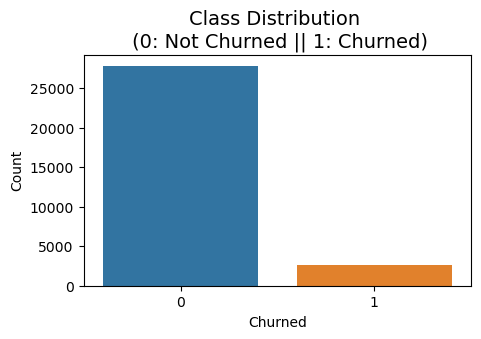

In [56]:
plt.figure(figsize=(5,3))

sns.countplot(x = High_value_customers['Churned'])
plt.title('Class Distribution \n (0: Not Churned || 1: Churned)', fontsize=14)
plt.ylabel('Count')

plt.show()

In [57]:
# Apply SMOTE to the training set

smote = SMOTE(random_state= 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

print("After Data Imbalance Treatment: ")
print("X train shape : ", X_train_smote.shape)
print("y train shape : ", y_train_smote.shape)

After Data Imbalance Treatment: 
X train shape :  (38934, 33)
y train shape :  (38934,)


In [58]:
def evaluate_model(y_true, y_pred):
    confusion = metrics.confusion_matrix(y_true, y_pred)
    TP = confusion[1,1] 
    TN = confusion[0,0] 
    FP = confusion[0,1] 
    FN = confusion[1,0] 
    
    accuracy_sc = metrics.accuracy_score(y_true, y_pred)
    sensitivity_score = TP / float(TP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    return accuracy_sc, sensitivity_score, precision,recall

In [59]:
def calculate_vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending=False)
    print(vif)

### Using Decision Tree

In [60]:
# creating base model without tunning
dt_base  = DecisionTreeClassifier(random_state=42, max_depth = 4)                                                                
dt_base.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [61]:
y_train_pred = dt_base.predict(X_train_smote)
y_test_pred = dt_base.predict(X_test)

In [62]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      8344
           1       0.40      0.63      0.49       770

    accuracy                           0.89      9114
   macro avg       0.68      0.77      0.71      9114
weighted avg       0.92      0.89      0.90      9114



### Hyper-parameter tunning for the Decision tree

In [63]:
dt = DecisionTreeClassifier(random_state= 42)
params = {
    "max_depth":[5,10,15,20,25],
    "min_samples_leaf" : [20,50,80,120]
}


grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                          n_jobs=-1, verbose=1, scoring="accuracy")

In [64]:
grid_search.fit(X_train_smote,y_train_smote)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [20, 50, 80, 120]},
             scoring='accuracy', verbose=1)

In [65]:
grid_search.best_score_

0.9060467096291193

In [66]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=25, min_samples_leaf=20, random_state=42)

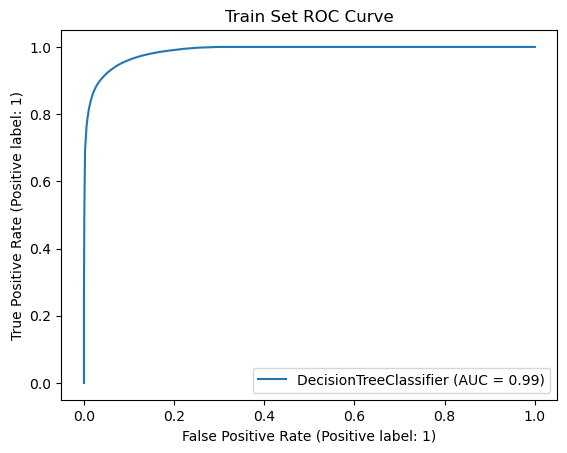

In [67]:

# First subplot: ROC curve for the training set
RocCurveDisplay.from_estimator(dt_best, X_train_smote, y_train_smote)
plt.title("Train Set ROC Curve")
plt.show()

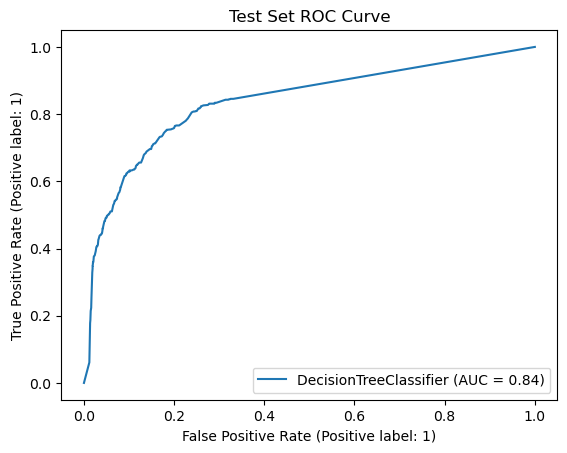

In [68]:
# Second subplot: ROC curve for the test set
RocCurveDisplay.from_estimator(dt_best, X_test, y_test)
plt.title("Test Set ROC Curve")
plt.show()

In [70]:
evaluation_df = pd.DataFrame(data=np.zeros((6,2)), index=['Logistic Regression(Train)','Logistic Regression(Test)','Decision Tree(Train)' ,'Decision Tree(Test)','Random Forest(Train)','Random Forest(Test)'], columns=['Accuracy', 'Sensitivity'])


In [71]:
accuracy_train_sc, sensitivity_train_sc, precision_train,recall_train = evaluate_model(y_train_smote,y_train_pred)

accuracy_test_sc, sensitivity_test_sc, precision_test,recall_test = evaluate_model(y_test,y_test_pred)

evaluation_df.loc['Decision Tree(Train)', 'Accuracy'] = round(accuracy_train_sc, 3)
evaluation_df.loc['Decision Tree(Train)', 'Sensitivity'] = round(sensitivity_train_sc,3)

evaluation_df.loc['Decision Tree(Test)', 'Accuracy'] = round(accuracy_test_sc, 3)
evaluation_df.loc['Decision Tree(Test)', 'Sensitivity'] = round(sensitivity_test_sc,3)
evaluation_df

,Accuracy,Sensitivity
Logistic Regression(Train),0.000,0.000
Logistic Regression(Test),0.000,0.000
Decision Tree(Train),0.827,0.734
Decision Tree(Test),0.888,0.634
Random Forest(Train),0.000,0.000
Random Forest(Test),0.000,0.000


### Using Random Forest with Hyper-parameter tunning

In [72]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [73]:
params = {
    'max_depth': [10,15,20,25],
    'min_samples_leaf': [30,50,100,200],
    'n_estimators': [10,25,50]
}

In [74]:
grid_search = GridSearchCV(estimator=rf, param_grid=params,cv=4, n_jobs=-1,verbose=1, scoring='accuracy')

In [75]:
%%time
grid_search.fit(X_train_smote,y_train_smote)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
CPU times: total: 30.7 s
Wall time: 7min 32s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25],
                         'min_samples_leaf': [30, 50, 100, 200],
                         'n_estimators': [10, 25, 50]},
             scoring='accuracy', verbose=1)

In [76]:
grid_search.best_score_

0.9201474705434358

In [77]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=30, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [78]:
# Make predictions on the test set
y_train_pred = rf_best.predict(X_train_smote)

# Evaluate the model
print(classification_report(y_train_smote, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     19467
           1       0.95      0.93      0.94     19467

    accuracy                           0.94     38934
   macro avg       0.94      0.94      0.94     38934
weighted avg       0.94      0.94      0.94     38934



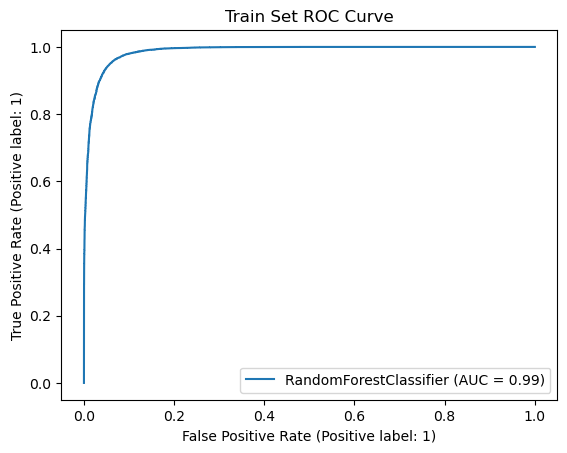

In [79]:
# First subplot: ROC curve for the training set
RocCurveDisplay.from_estimator(rf_best, X_train_smote, y_train_smote)
plt.title("Train Set ROC Curve")
plt.show()

In [80]:
imp_df = pd.DataFrame({
    "features": X_train_smote.columns,
    "Imp" : rf_best.feature_importances_
})
imp_df.sort_values(by='Imp', ascending=False)

,features,Imp
2,no_of_days_since_last_rech_data,0.164333
1,no_of_days_since_last_rech,0.089046
26,derived_max_rech_amt,0.076449
22,derived_std_ic_mou,0.071337
19,derived_loc_ic_mou,0.059871
3,derived_arpu,0.043757
6,derived_loc_og_t2t_mou,0.039072
7,derived_loc_og_t2m_mou,0.038836
16,derived_loc_ic_t2t_mou,0.038291
17,derived_loc_ic_t2m_mou,0.035228


In [81]:
# Make predictions on the test set
y_test_pred = rf_best.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8344
           1       0.53      0.66      0.59       770

    accuracy                           0.92      9114
   macro avg       0.75      0.80      0.77      9114
weighted avg       0.93      0.92      0.93      9114



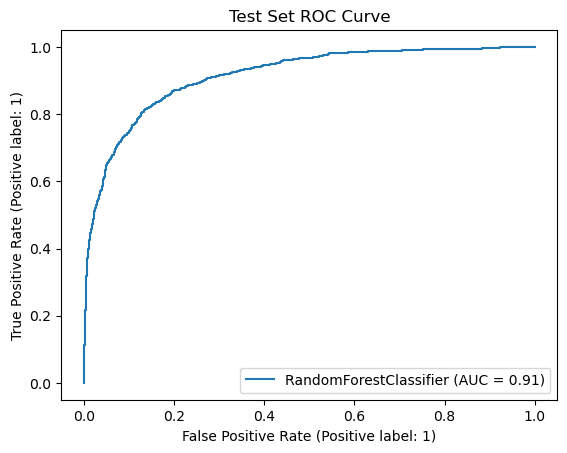

In [82]:
# Second subplot: ROC curve for the test set
RocCurveDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Test Set ROC Curve")
plt.show()

In [83]:
accuracy_train_sc, sensitivity_train_sc, precision_train,recall_train = evaluate_model(y_train_smote,y_train_pred)

accuracy_test_sc, sensitivity_test_sc, precision_test,recall_test = evaluate_model(y_test,y_test_pred)

evaluation_df.loc['Random Forest(Train)', 'Accuracy'] = round(accuracy_train_sc, 3)
evaluation_df.loc['Random Forest(Train)', 'Sensitivity'] = round(sensitivity_train_sc,3)

evaluation_df.loc['Random Forest(Test)', 'Accuracy'] = round(accuracy_test_sc, 3)
evaluation_df.loc['Random Forest(Test)', 'Sensitivity'] = round(sensitivity_test_sc,3)
evaluation_df

,Accuracy,Sensitivity
Logistic Regression(Train),0.000,0.000
Logistic Regression(Test),0.000,0.000
Decision Tree(Train),0.827,0.734
Decision Tree(Test),0.888,0.634
Random Forest(Train),0.942,0.931
Random Forest(Test),0.921,0.662


### Using Logistic Model
#### First using Statsmodel to see all the features significant level.

In [84]:
logm1 = sm.GLM(y_train_smote, (sm.add_constant(X_train_smote)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Churned   No. Observations:                38934
Model:                            GLM   Df Residuals:                    38900
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16848.
Date:                Sun, 04 Aug 2024   Deviance:                       33696.
Time:                        13:32:31   Pearson chi2:                 4.25e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4060
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.9634      0.036    -53.855      0.000      -2.035      -1.892
aon                                -0.0007   1.78e-05    -37.148      0.000      -0.001      -0.001
no_of_days_since_last_rech          0.1099      0.003     35.474      0.000       0.104       0.116
no_of_days_since_last_rech_data     0.0291      0.001     45.127      0.000       0.028       0.030
derived_arpu                     4.228e-05      0.000      0.219      0.827      -0.000       0.000
derived_onnet_mou                  -0.0047      0.001     -4.457      0.000      -0.007      -0.003
derived_offnet_mou                 -0.0031      0.001     -6.044      0.000      -0.004      -0.002
derived_loc_og_t2t_mou              0.0093      0.002      4.109      0.000       0.005       0.014
derived_loc_og_t2m_mou              0.0048      0.001      3.686      0.000       0.002       0.007
derived_loc_og_t2f_mou             -0.1960      0.020     -9.808      0.000      -0.235      -0.157
derived_loc_og_t2c_mou             -0.8410      0.096     -8.775      0.000      -1.029      -0.653
derived_loc_og_mou                 -0.0075      0.001     -6.992      0.000      -0.010      -0.005
derived_std_og_t2t_mou              0.0118      0.022      0.532      0.594      -0.032       0.055
derived_std_og_t2m_mou             -0.0092      0.005     -1.735      0.083      -0.020       0.001
derived_std_og_mou              -7.336e-05      0.003     -0.022      0.982      -0.007       0.006
derived_spl_og_mou                  0.0168      0.006      2.931      0.003       0.006       0.028
derived_total_og_mou                0.0063      0.000     20.196      0.000       0.006       0.007
derived_loc_ic_t2t_mou              0.0093      0.002      5.997      0.000       0.006       0.012
derived_loc_ic_t2m_mou              0.0048      0.001      5.108      0.000       0.003       0.007
derived_loc_ic_t2f_mou             -0.0207      0.005     -4.327      0.000      -0.030      -0.011
derived_loc_ic_mou                 -0.0064      0.001     -6.981      0.000      -0.008      -0.005
derived_std_ic_t2t_mou             -0.0690      0.017     -3.969      0.000      -0.103      -0.035
derived_std_ic_t2m_mou             -0.0071      0.005     -1.384      0.166      -0.017       0.003
derived_std_ic_mou                  0.0154      0.003      4.677      0.000       0.009       0.022
derived_total_ic_mou                0.0060      0.000     14.862      0.000       0.005       0.007
derived_total_rech_num              0.0128      0.006      2.256      0.024       0.002       0.024
derived_total_rech_amt             -0.0005      0.000     -3.020      0.003      -0.001      -0.000
derived_max_rech_amt                0.0019      0.000      6.382      0.000       0

In [85]:
####  Using  RFE for Feature Selection

In [86]:
logreg  = LogisticRegression()

In [87]:
rfe = RFE(logreg, n_features_to_select= 20)
rfe = rfe.fit(X_train_smote, y_train_smote)

In [90]:
list(zip(X_train_smote.columns, rfe.support_,rfe.ranking_))

[('aon', False, 10),
 ('no_of_days_since_last_rech', True, 1),
 ('no_of_days_since_last_rech_data', True, 1),
 ('derived_arpu', False, 14),
 ('derived_onnet_mou', False, 3),
 ('derived_offnet_mou', False, 6),
 ('derived_loc_og_t2t_mou', False, 8),
 ('derived_loc_og_t2m_mou', False, 5),
 ('derived_loc_og_t2f_mou', True, 1),
 ('derived_loc_og_t2c_mou', True, 1),
 ('derived_loc_og_mou', False, 2),
 ('derived_std_og_t2t_mou', True, 1),
 ('derived_std_og_t2m_mou', True, 1),
 ('derived_std_og_mou', True, 1),
 ('derived_spl_og_mou', False, 7),
 ('derived_total_og_mou', True, 1),
 ('derived_loc_ic_t2t_mou', True, 1),
 ('derived_loc_ic_t2m_mou', True, 1),
 ('derived_loc_ic_t2f_mou', True, 1),
 ('derived_loc_ic_mou', True, 1),
 ('derived_std_ic_t2t_mou', True, 1),
 ('derived_std_ic_t2m_mou', True, 1),
 ('derived_std_ic_mou', True, 1),
 ('derived_total_ic_mou', True, 1),
 ('derived_total_rech_num', True, 1),
 ('derived_total_rech_amt', False, 13),
 ('derived_max_rech_amt', False, 4),
 ('derived_l

In [91]:
list(zip(X_train_smote.columns, rfe.support_, rfe.ranking_))

[('aon', False, 10),
 ('no_of_days_since_last_rech', True, 1),
 ('no_of_days_since_last_rech_data', True, 1),
 ('derived_arpu', False, 14),
 ('derived_onnet_mou', False, 3),
 ('derived_offnet_mou', False, 6),
 ('derived_loc_og_t2t_mou', False, 8),
 ('derived_loc_og_t2m_mou', False, 5),
 ('derived_loc_og_t2f_mou', True, 1),
 ('derived_loc_og_t2c_mou', True, 1),
 ('derived_loc_og_mou', False, 2),
 ('derived_std_og_t2t_mou', True, 1),
 ('derived_std_og_t2m_mou', True, 1),
 ('derived_std_og_mou', True, 1),
 ('derived_spl_og_mou', False, 7),
 ('derived_total_og_mou', True, 1),
 ('derived_loc_ic_t2t_mou', True, 1),
 ('derived_loc_ic_t2m_mou', True, 1),
 ('derived_loc_ic_t2f_mou', True, 1),
 ('derived_loc_ic_mou', True, 1),
 ('derived_std_ic_t2t_mou', True, 1),
 ('derived_std_ic_t2m_mou', True, 1),
 ('derived_std_ic_mou', True, 1),
 ('derived_total_ic_mou', True, 1),
 ('derived_total_rech_num', True, 1),
 ('derived_total_rech_amt', False, 13),
 ('derived_max_rech_amt', False, 4),
 ('derived_l

In [92]:
rfe_col = X_train_smote.columns[rfe.support_]

In [93]:
rfe_col

Index(['no_of_days_since_last_rech', 'no_of_days_since_last_rech_data',
       'derived_loc_og_t2f_mou', 'derived_loc_og_t2c_mou',
       'derived_std_og_t2t_mou', 'derived_std_og_t2m_mou',
       'derived_std_og_mou', 'derived_total_og_mou', 'derived_loc_ic_t2t_mou',
       'derived_loc_ic_t2m_mou', 'derived_loc_ic_t2f_mou',
       'derived_loc_ic_mou', 'derived_std_ic_t2t_mou',
       'derived_std_ic_t2m_mou', 'derived_std_ic_mou', 'derived_total_ic_mou',
       'derived_total_rech_num', 'derived_last_day_rch_amt',
       'derived_sachet_2g', 'derived_vbc_3g'],
      dtype='object')

**Building model with RFE selected features**

In [95]:
X_train_sm = sm.add_constant(X_train_smote[col])
logm2 = sm.GLM(y_train_smote,X_train_sm,family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Churned   No. Observations:                38934
Model:                            GLM   Df Residuals:                    38932
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21136.
Date:                Sun, 04 Aug 2024   Deviance:                       42273.
Time:                        13:33:56   Pearson chi2:                 4.10e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2596
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.8286      0.023    -81.126      0.000      -1.873      -1.784
no_of_days_since_last_rech_data     0.0484      0.001     93.208      0.000       0.047       0.049
===================================================================================================
"""

In [96]:
# Getting the predicted value on train set
y_train_pred = res.predict(X_train_sm)
y_train_pred= y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.77212043, 0.27738518, 0.15035807, 0.2584079 , 0.91542986,
       0.15664577, 0.57464073, 0.70714446, 0.90762893, 0.84609252])

In [97]:
#### Creating  a dataframe with actual churn flag and the predicted probabilities

In [98]:
y_train_pred_final = pd.DataFrame({"Cust_ID":y_train_smote.index,'Churn': y_train_smote.values,"Churn_Prob": y_train_pred})
## Creating new column with predicted with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Churn_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final.head()

,Cust_ID,Churn,Churn_Prob,Predicted
0,0,0,0.772120,1
1,1,0,0.277385,0
2,2,0,0.150358,0
3,3,0,0.258408,0
4,4,0,0.915430,1


In [99]:
accuracy_sc, sensitivity_score, precision,recall = evaluate_model(y_train_pred_final.Churn,y_train_pred_final.Predicted)
print("=== Logistic model with top 20 features===")
print("Accuracy score:" , accuracy_sc)
print("Precision:" , precision)
print("Recall:" , recall)


=== Logistic model with top 20 features===
Accuracy score: 0.7544819438023321
Precision: 0.7611216529622602
Recall: 0.7417681204088971


In [100]:
### Checking VIF

In [102]:
calculate_vif(X_train_smote[rfe_col])

                           Features    VIF
11               derived_loc_ic_mou  12.29
9            derived_loc_ic_t2m_mou   6.56
6                derived_std_og_mou   5.48
14               derived_std_ic_mou   4.56
15             derived_total_ic_mou   4.52
1   no_of_days_since_last_rech_data   3.89
5            derived_std_og_t2m_mou   3.59
0        no_of_days_since_last_rech   3.51
13           derived_std_ic_t2m_mou   3.50
7              derived_total_og_mou   3.07
16           derived_total_rech_num   2.81
8            derived_loc_ic_t2t_mou   2.67
4            derived_std_og_t2t_mou   2.28
12           derived_std_ic_t2t_mou   1.77
18                derived_sachet_2g   1.71
10           derived_loc_ic_t2f_mou   1.25
19                   derived_vbc_3g   1.19
17         derived_last_day_rch_amt   1.18
2            derived_loc_og_t2f_mou   1.14
3            derived_loc_og_t2c_mou   1.12


Since the VIF for "derived_loc_ic_mou"  is very high, we need to drop it

In [103]:
rfe_col = rfe_col.drop('derived_loc_ic_mou')

In [104]:
# Re-run the model using selected variables
X_train_sm = sm.add_constant(X_train_smote[rfe_col])
logm3 = sm.GLM(y_train_smote, X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Churned   No. Observations:                38934
Model:                            GLM   Df Residuals:                    38914
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17894.
Date:                Sun, 04 Aug 2024   Deviance:                       35789.
Time:                        13:34:34   Pearson chi2:                 3.89e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3732
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.4934      0.033    -76.214      0.000      -2.558      -2.429
no_of_days_since_last_rech          0.1016      0.003     34.453      0.000       0.096       0.107
no_of_days_since_last_rech_data     0.0318      0.001     54.107      0.000       0.031       0.033
derived_loc_og_t2f_mou             -0.2904      0.019    -15.596      0.000      -0.327      -0.254
derived_loc_og_t2c_mou             -0.6677      0.078     -8.515      0.000      -0.821      -0.514
derived_std_og_t2t_mou             -0.0014      0.019     -0.074      0.941      -0.040       0.037
derived_std_og_t2m_mou             -0.0167      0.005     -3.590      0.000      -0.026      -0.008
derived_std_og_mou                  0.0041      0.003      1.336      0.182      -0.002       0.010
derived_total_og_mou                0.0035      0.000     17.946      0.000       0.003       0.004
derived_loc_ic_t2t_mou             -0.0004      0.001     -0.359      0.720      -0.002       0.002
derived_loc_ic_t2m_mou             -0.0025      0.001     -4.711      0.000      -0.004      -0.001
derived_loc_ic_t2f_mou             -0.0408      0.004     -9.434      0.000      -0.049      -0.032
derived_std_ic_t2t_mou             -0.0884      0.017     -5.275      0.000      -0.121      -0.056
derived_std_ic_t2m_mou             -0.0075      0.005     -1.516      0.130      -0.017       0.002
derived_std_ic_mou                  0.0168      0.003      5.372      0.000       0.011       0.023
derived_total_ic_mou                0.0055      0.000     17.228      0.000       0.005       0.006
derived_total_rech_num              0.0121      0.005      2.613      0.009       0.003       0.021
derived_last_day_rch_amt            0.0051      0.000     24.639      0.000       0.005       0.006
derived_sachet_2g                   0.4008      0.026     15.177      0.000       0.349       0.453
derived_vbc_3g                      0.0050      0.000     13.140      0.000       0.004       0.006
===================================================================================================
"""

In [105]:
# Predit on train data

# Getting the predicted value on train set
y_train_pred = res.predict(X_train_sm)
y_train_pred= y_train_pred.values.reshape(-1)

y_train_pred_final = pd.DataFrame({"Cust_ID":y_train_smote.index,'Churn': y_train_smote.values,"Churn_Prob": y_train_pred})
## Creating new column with predicted with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Churn_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final.head()

,Cust_ID,Churn,Churn_Prob,Predicted
0,0,0,0.807374,1
1,1,0,0.214971,0
2,2,0,0.212966,0
3,3,0,0.164453,0
4,4,0,0.591349,1


In [106]:
accuracy_sc, sensitivity_score, precision,recall = evaluate_model(y_train_pred_final.Churn,y_train_pred_final.Predicted)
print("=== Logistic model with top 20 features===")
print("Accuracy score:" , accuracy_sc)
print("Precision:" , precision)
print("Recall:" , recall)

=== Logistic model with top 20 features===
Accuracy score: 0.7864334514819952
Precision: 0.7886726030234003
Recall: 0.7825550932347048


In [107]:
calculate_vif(X_train_smote[rfe_col])

                           Features   VIF
6                derived_std_og_mou  5.48
13               derived_std_ic_mou  4.52
1   no_of_days_since_last_rech_data  3.88
14             derived_total_ic_mou  3.72
5            derived_std_og_t2m_mou  3.59
0        no_of_days_since_last_rech  3.51
12           derived_std_ic_t2m_mou  3.50
7              derived_total_og_mou  3.02
15           derived_total_rech_num  2.80
4            derived_std_og_t2t_mou  2.28
9            derived_loc_ic_t2m_mou  2.02
11           derived_std_ic_t2t_mou  1.77
17                derived_sachet_2g  1.71
8            derived_loc_ic_t2t_mou  1.43
18                   derived_vbc_3g  1.19
16         derived_last_day_rch_amt  1.18
2            derived_loc_og_t2f_mou  1.14
10           derived_loc_ic_t2f_mou  1.13
3            derived_loc_og_t2c_mou  1.12


In [108]:
#dropping "derived_loc_ic_t2m_mou"	0.739
rfe_col = rfe_col.drop('derived_loc_ic_t2m_mou', 1)

In [109]:
# Re-run the model using selected variables
X_train_sm = sm.add_constant(X_train_smote[rfe_col])
logm4 = sm.GLM(y_train_smote, X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Churned   No. Observations:                38934
Model:                            GLM   Df Residuals:                    38915
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17906.
Date:                Sun, 04 Aug 2024   Deviance:                       35811.
Time:                        13:34:36   Pearson chi2:                 3.90e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3728
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.4991      0.033    -76.390      0.000      -2.563      -2.435
no_of_days_since_last_rech          0.1019      0.003     34.552      0.000       0.096       0.108
no_of_days_since_last_rech_data     0.0321      0.001     54.637      0.000       0.031       0.033
derived_loc_og_t2f_mou             -0.2972      0.019    -15.961      0.000      -0.334      -0.261
derived_loc_og_t2c_mou             -0.6889      0.078     -8.777      0.000      -0.843      -0.535
derived_std_og_t2t_mou             -0.0046      0.020     -0.238      0.812      -0.043       0.034
derived_std_og_t2m_mou             -0.0179      0.005     -3.856      0.000      -0.027      -0.009
derived_std_og_mou                  0.0040      0.003      1.295      0.195      -0.002       0.010
derived_total_og_mou                0.0035      0.000     18.049      0.000       0.003       0.004
derived_loc_ic_t2t_mou              0.0001      0.001      0.132      0.895      -0.002       0.002
derived_loc_ic_t2f_mou             -0.0409      0.004     -9.436      0.000      -0.049      -0.032
derived_std_ic_t2t_mou             -0.0929      0.017     -5.537      0.000      -0.126      -0.060
derived_std_ic_t2m_mou             -0.0086      0.005     -1.744      0.081      -0.018       0.001
derived_std_ic_mou                  0.0189      0.003      6.121      0.000       0.013       0.025
derived_total_ic_mou                0.0045      0.000     18.690      0.000       0.004       0.005
derived_total_rech_num              0.0122      0.005      2.634      0.008       0.003       0.021
derived_last_day_rch_amt            0.0052      0.000     24.682      0.000       0.005       0.006
derived_sachet_2g                   0.4031      0.026     15.258      0.000       0.351       0.455
derived_vbc_3g                      0.0050      0.000     13.258      0.000       0.004       0.006
===================================================================================================
"""

In [110]:
# Predit on train data

# Getting the predicted value on train set
y_train_pred = res.predict(X_train_sm)
y_train_pred= y_train_pred.values.reshape(-1)

y_train_pred_final = pd.DataFrame({"Cust_ID":y_train_smote.index,'Churn': y_train_smote.values,"Churn_Prob": y_train_pred})
## Creating new column with predicted with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Churn_Prob.map(lambda x : 1 if x>0.5 else 0)
y_train_pred_final.head()

,Cust_ID,Churn,Churn_Prob,Predicted
0,0,0,0.843314,1
1,1,0,0.214943,0
2,2,0,0.217521,0
3,3,0,0.158325,0
4,4,0,0.568200,1


In [111]:
accuracy_train_sc, sensitivity_train_sc, precision_train,recall_train = evaluate_model(y_train_pred_final.Churn,y_train_pred_final.Predicted)
print("=== Logistic model with top 20 features===")
print("Accuracy score:" , accuracy_train_sc)
print("Precision:" , precision_train)
print("Recall:" , recall_train)

=== Logistic model with top 20 features===
Accuracy score: 0.7857142857142857
Precision: 0.7873230705651411
Recall: 0.7829146761185596


In [112]:
calculate_vif(X_train_smote[rfe_col])

                           Features   VIF
6                derived_std_og_mou  5.47
12               derived_std_ic_mou  4.47
1   no_of_days_since_last_rech_data  3.85
5            derived_std_og_t2m_mou  3.58
0        no_of_days_since_last_rech  3.50
11           derived_std_ic_t2m_mou  3.49
7              derived_total_og_mou  3.01
14           derived_total_rech_num  2.80
13             derived_total_ic_mou  2.52
4            derived_std_og_t2t_mou  2.27
10           derived_std_ic_t2t_mou  1.77
16                derived_sachet_2g  1.71
8            derived_loc_ic_t2t_mou  1.43
17                   derived_vbc_3g  1.19
15         derived_last_day_rch_amt  1.18
2            derived_loc_og_t2f_mou  1.13
9            derived_loc_ic_t2f_mou  1.12
3            derived_loc_og_t2c_mou  1.11


### Drawing ROC Curve

In [114]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='Regeression ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

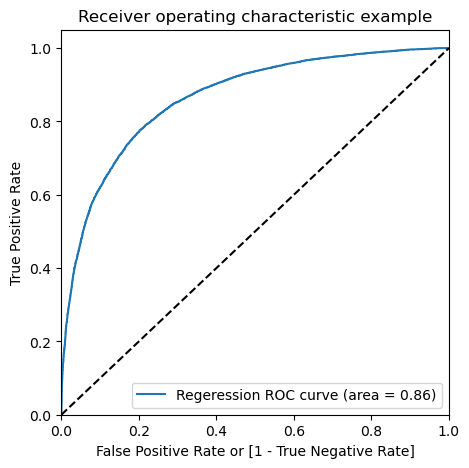

In [115]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [116]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
    
y_train_pred_final.head()

,Cust_ID,Churn,Churn_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0,0.843314,1,1,1,1,1,1,1,1,1,1,0
1,1,0,0.214943,0,1,1,1,0,0,0,0,0,0,0
2,2,0,0.217521,0,1,1,1,0,0,0,0,0,0,0
3,3,0,0.158325,0,1,1,0,0,0,0,0,0,0,0
4,4,0,0.568200,1,1,1,1,1,1,1,0,0,0,0


In [117]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)



     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.617661  0.980993  0.254328
0.2   0.2  0.705553  0.944932  0.466174
0.3   0.3  0.752684  0.901269  0.604099
0.4   0.4  0.778805  0.849489  0.708121
0.5   0.5  0.785714  0.782915  0.788514
0.6   0.6  0.777855  0.703139  0.852571
0.7   0.7  0.757949  0.611188  0.904711
0.8   0.8  0.712488  0.475317  0.949658
0.9   0.9  0.621205  0.256845  0.985565


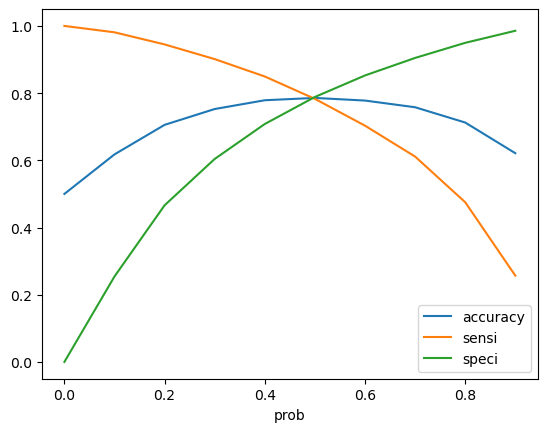

In [118]:
cutoff_df.plot.line(x= 'prob', y=['accuracy','sensi','speci'])
plt.show()

**From the curve above, 0.5 is the optimum pont to take as a cutoff probability**

In [119]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map(lambda x : 1 if x>0.5 else 0)

In [128]:
y_train_pred_final.head()

,Cust_ID,Churn,Churn_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0,0.843314,1,1,1,1,1,1,1,1,1,1,0,1
1,1,0,0.214943,0,1,1,1,0,0,0,0,0,0,0,0
2,2,0,0.217521,0,1,1,1,0,0,0,0,0,0,0,0
3,3,0,0.158325,0,1,1,0,0,0,0,0,0,0,0,0
4,4,0,0.568200,1,1,1,1,1,1,1,0,0,0,0,1


since Sensitivity and Recall are same "True Positive Rate" (TP/(TP+FN)) which are we focusing on

### Making prediction on Test set

In [122]:
X_test = X_test[rfe_col]
X_test_sm = sm.add_constant(X_test)

y_test_pred = res.predict(X_test_sm)
y_test_pred_df = pd.DataFrame({"Churn": y_test.values.reshape(-1), 'Churn_Prob': y_test_pred})
y_test_pred_df['predicted'] = y_test_pred_df.Churn_Prob.map(lambda x: 1 if x>0.5 else 0)
y_test_pred_df.head()

,Churn,Churn_Prob,predicted
mobile_number,,,
7002084822,0,0.224683,0
7000777567,0,0.040769,0
7001095256,0,0.056643,0
7001786221,0,0.083433,0
7000090908,0,0.194287,0


In [123]:
# top 10 predictors(except constant)
top_predictors = res.params
top_preddf = pd.DataFrame(top_predictors)
top_preddf.drop('const', axis=0, inplace =  True)
top_preddf

,0
no_of_days_since_last_rech,0.101869
no_of_days_since_last_rech_data,0.032057
derived_loc_og_t2f_mou,-0.297205
derived_loc_og_t2c_mou,-0.688877
derived_std_og_t2t_mou,-0.004633
derived_std_og_t2m_mou,-0.017894
derived_std_og_mou,0.004012
derived_total_og_mou,0.003508
derived_loc_ic_t2t_mou,0.000141
derived_loc_ic_t2f_mou,-0.040921


In [124]:

accuracy_test_sc, sensitivity_test_sc, precision_test,recall_test = evaluate_model(y_test_pred_df.Churn,y_test_pred_df.predicted)

print("Accuracy score:" , accuracy_test_sc)
print("Precision:" , precision_test)
print("Recall:" , recall_test)
print("Sensitivity:" , sensitivity_test_sc)

Accuracy score: 0.7841781874039938
Precision: 0.24714828897338403
Recall: 0.7597402597402597
Sensitivity: 0.7597402597402597


In [125]:

evaluation_df.loc['Logistic Regression(Train)', 'Accuracy'] = round(accuracy_train_sc, 3)
evaluation_df.loc['Logistic Regression(Train)', 'Sensitivity'] = round(sensitivity_train_sc,3)

evaluation_df.loc['Logistic Regression(Test)', 'Accuracy'] = round(accuracy_test_sc, 3)
evaluation_df.loc['Logistic Regression(Test)', 'Sensitivity'] = round(sensitivity_test_sc,3)
evaluation_df

,Accuracy,Sensitivity
Logistic Regression(Train),0.786,0.783
Logistic Regression(Test),0.784,0.760
Decision Tree(Train),0.827,0.734
Decision Tree(Test),0.888,0.634
Random Forest(Train),0.942,0.931
Random Forest(Test),0.921,0.662


### Drawing insights from these top Predictors

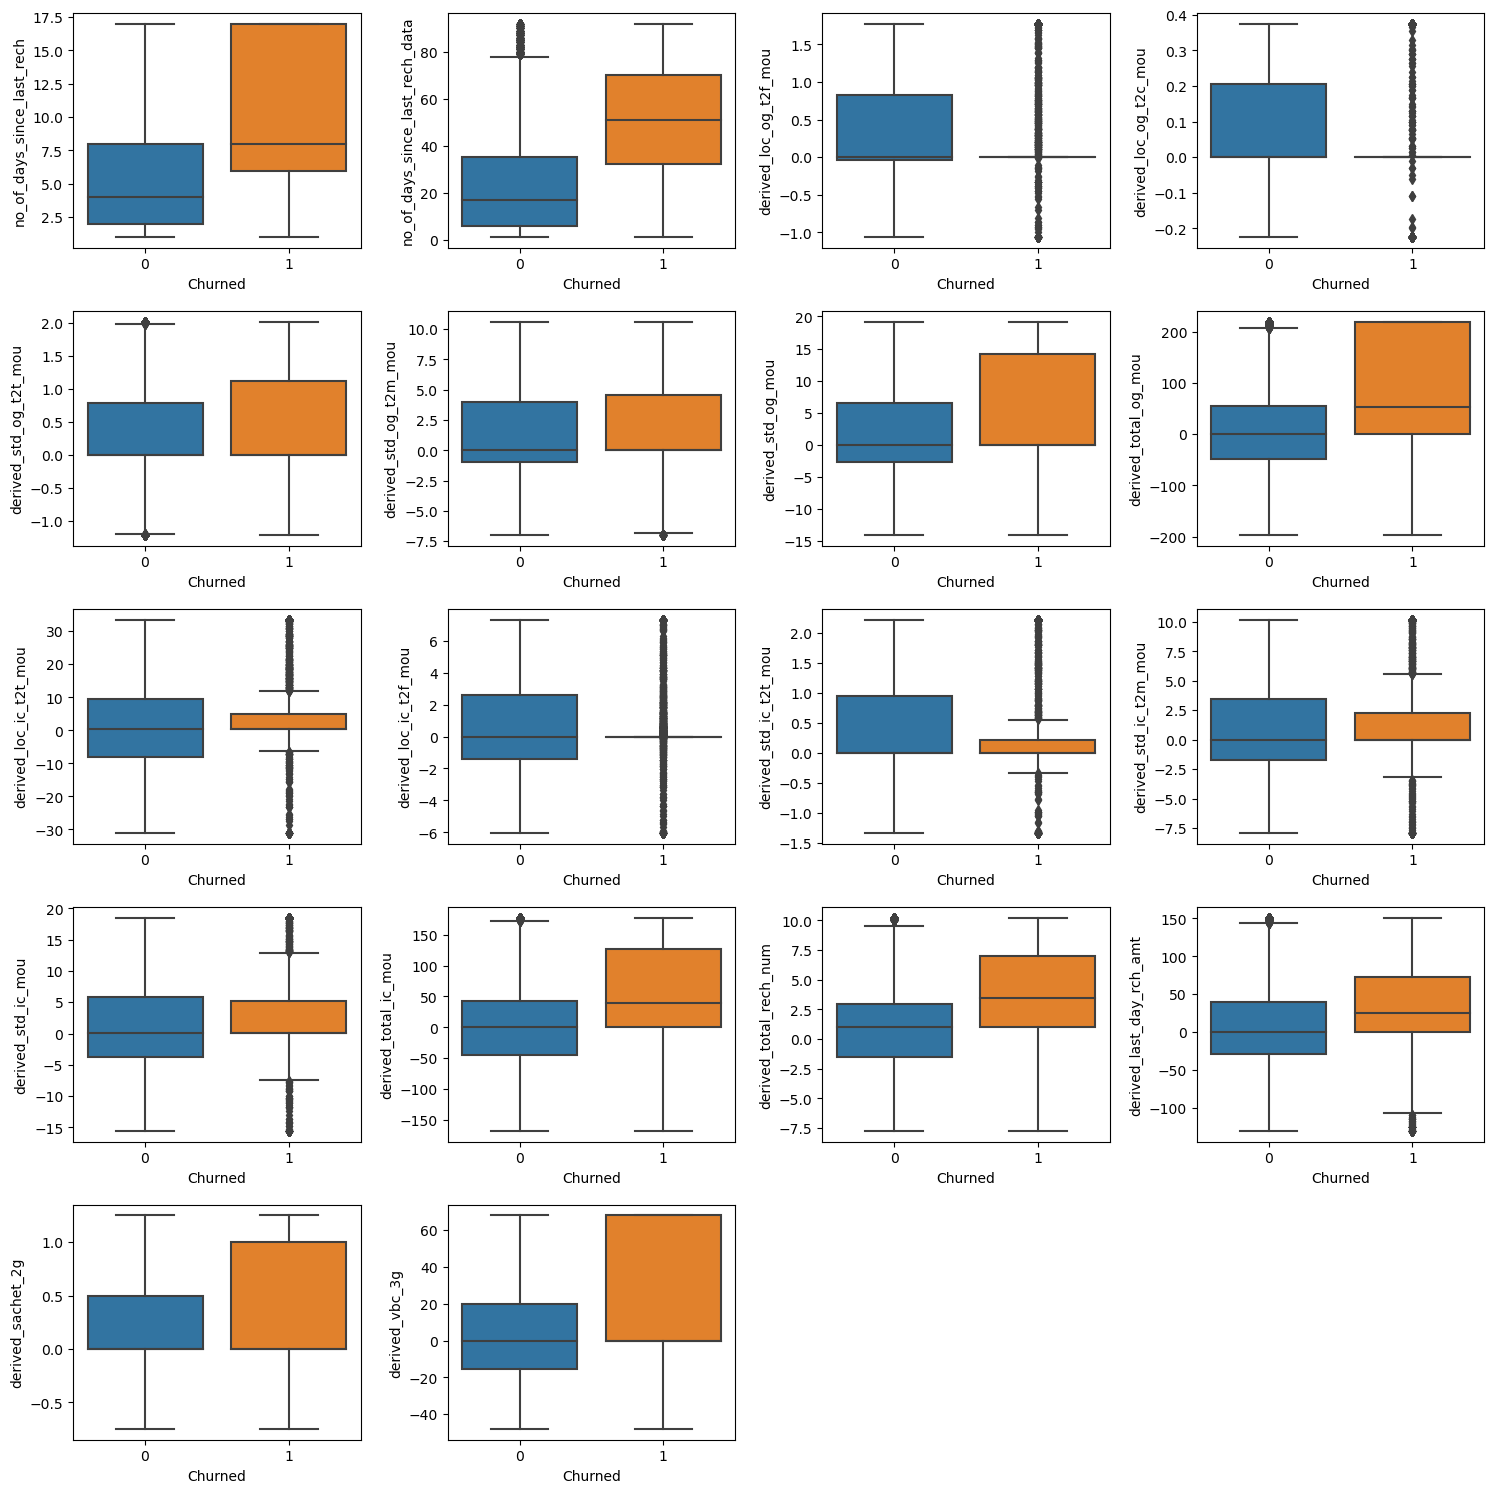

In [126]:
fig=plt.subplots(figsize=(15,15))

for i, col in enumerate(top_preddf.index):
    plt.subplot(5,4, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.boxplot(y = col, x = 'Churned', data = High_value_customers)
    plt.tight_layout()

### Observation and Recommendation for Reducing Customer Churn:

1. Customers with 'no_of_days_since_last_rech' 17 or more are most likely churn. 
Sales team may focus on customers who have not made a recharge in last 17 days or more and provide them with 
special talk-time offers to reduce churn.


2. Customers with 'no_of_days_since_last_rech_data'  50 or more are most likely churn. Sales team may focus on
customers who have not made a recharge for mobile data in last 1.5 months or more and provide them with special
data recharge offers to reduce churn.


3. Customers with high positive values in 'derived_last_day_rch_amt' are going to churn. Sales team may 
focus on the customer whose derived_last_day_rch_amt >= 50. Drop in last recharge amount in action phase is indicator of churn.
(since the derived feature is calculated from average of good phase month and subtracted from action phase)


4. Customers with aon (age of network) < 800 are more likely to churn than others. 
Customers using the telecom operator for more than 1000 days or 3 years are proven to be loyal customers (aon>1000).
Churned customers have average aon of 800, that means customers using the telecom operator for 2 years or less (800 days or less) might churn.


5. Positive values of 'derived_tot_rech_amt' and 'derived_av_rech_amt_data' indicate drop in maximum recharge amount and 
recharge data in action phase, which in turn indicates high probability of Customer churn.


6. High positive values of 'derived_vol_2g_mb' means for churned customers means huge drop in 2g data usage in action phase for 
customer who churned. Telecom company may need to revise its 2g/3g data plans in order to retain customers.

### Conclusion

#### Predictor Model
Since reducing Customer churns with attractive offers is less expensive than making new customers. Sensitivity score is considered for the building the final predictor model.

**The final model logistic could predict 76% of the churned customers correctly out of all the churned customers. (sensitivity) on a test data**

**Accuracy score 0.79 means 79% of the predictions made by the final model are correct out of all the predictions on test set.**